In [1]:
%matplotlib inline
import numpy as np
import torch
import sys
sys.path.append('../')
from voting_games.werewolf_env_v0 import plurality_env, Roles, Phase
from notebooks.learning_agents.models import ActorCriticAgent
from notebooks.learning_agents.utils import play_static_game, play_recurrent_game
from notebooks.learning_agents.static_agents import (
    random_plurality_villager, 
    random_coordinated_plurality_villager, 
    random_agent,
    random_plurality_wolf,
    revenge_plurality_wolf,
    coordinated_revenge_plurality_wolf)
import notebooks.learning_agents.stats as indicators
import random
import copy
from matplotlib import pyplot as plt
from tqdm import tqdm
from tabulate import tabulate

# Plurality Voting

Plurality is a voting method where each voter picks a single candidate, and the candidate with the most votes is selected. It's simplicity has lead to wide adoption, however there are quite a few drawbacks, one of which being the limited expressibility of a voter.

In our Werewolf plurality implementation, an agent can only select a single target, and cannot express their beliefs towards the remaining agents. This is also the voting mechanism used in every paper involving the Werewolf game up to now, so we want to see how our trained agents compare.


(p-analysis)=
## Quick Takeaway

Trained villager agents performed better than CL-Targets villagers, even when pitted against werewolf policies they were not trained against. Using the below indicators, we have a theory that these agents use accusation phases to implicitly signal intent by targetting dead villagers to then workout who they believe are actually werewolves and who are truly villagers.

## Win Rates

We want to see how our hand-crafted agents play against eachother, with special interest given to coordinated random villagers and wolves. 

As expected, the coordinated random villagers and wolves performed the best out of the static policies {cite}`braverman2008mafia`.
Our agent, trained against coordinated random wolves, performed better than all of our hand-crafted villager policies. They also generalized well against our other wolf policies, and actually had the highest win rates across the board.

Below is code to generate the following table of 1000 runs between each villager policy and each werewolf policy. We base our discussion around this markdown table.

```{warning}
Our trained agent, Trained-CRWolves, is an outlier that got above a $0.40$ win-rate. On average, trained plurality agents did not do as well.
```

Villager Strategy vs. | [Random](rwolves) | [CRWolves](crwolves) | [RevWolves](revwolves) | [CRevWolves](crevwolves)
| --- | --- | --- | --- | --- | 
[Random](r-villagers) | 0.597 | 0.042 | 0.076 | 0.074 |
[L-Targets](l-villagers) | 0.705 | 0.125 | 0.192 | 0.244 |
[CL-Targets](cl-villagers) | 0.653 | 0.314 | 0.304 | 0.281 |
[Trained-CRWolves](trained-villagers) | **0.83** | **0.473** | **0.45** | **0.503** |

In [2]:
env = plurality_env(num_agents=10, werewolves=2, num_accusations=2)
observations, _, _, _, _ = env.reset()

obs_size= env.convert_obs(observations['player_0']['observation']).shape[-1]

trained_plurality_agent = ActorCriticAgent({"rec_hidden_size": 128,
                                        "rec_layers": 1, 
                                        "joint_mlp_size": 128,
                                        "split_mlp_size": 128,
                                        "num_votes": 1,
                                        "approval_states": 10},
                                        num_players=10,
                                        obs_size=obs_size)
trained_plurality_agent.load_state_dict(torch.load("../notebooks/stored_agents/lstm_first_no_one_hot_128_128/plurality_agent_10_score_46"))

num_games = 1000
print(f'10 players, with 2 wolves - number of games played : {num_games} \n')

rv_wins = []
rv_replays = []
for wolf_policy in [random_agent, random_plurality_wolf, revenge_plurality_wolf, coordinated_revenge_plurality_wolf]:
    wins, replays = play_static_game(env, wolf_policy, random_agent, num_times=num_games)
    rv_wins.append(wins/float(num_games))
    rv_replays.append(replays)

rpv_wins = []
rpv_replays = []
for wolf_policy in [random_agent, random_plurality_wolf, revenge_plurality_wolf, coordinated_revenge_plurality_wolf]:
    wins, replays = play_static_game(env, wolf_policy, random_plurality_villager, num_times=num_games)
    rpv_wins.append(wins/float(num_games))
    rpv_replays.append(replays)

cpv_wins = []
cpv_replays = []
for wolf_policy in [random_agent, random_plurality_wolf, revenge_plurality_wolf, coordinated_revenge_plurality_wolf]:
    wins, replays = play_static_game(env, wolf_policy, random_coordinated_plurality_villager, num_times=num_games)
    cpv_wins.append(wins/float(num_games))
    cpv_replays.append(replays)

tpv_wins = []
tpv_replays = []
for wolf_policy in [random_agent, random_plurality_wolf, revenge_plurality_wolf, coordinated_revenge_plurality_wolf]:
    # wins, replays = play_static_game(env, wolf_policy, random_agent, num_times=num_games)[0]/float(num_games)
    wins, replays = play_recurrent_game(env, wolf_policy, trained_plurality_agent, num_times=num_games, hidden_state_size=128, voting_type="plurality")
    tpv_wins.append(wins/float(num_games))
    tpv_replays.append(replays)

print(tabulate([['Random', *rv_wins], 
                ['L-Targets', *rpv_wins], 
                ['CL-Targets', *cpv_wins], 
                ['Trained-CRWolves', *tpv_wins]], 
               headers=["Villager Strategy vs", 
                        "Random", 
                        "CRWolves", 
                        "RevWolves",
                        "CRevWolves"]))

10 players, with 2 wolves - number of games played : 1000 

Villager Strategy vs      Random    CRWolves    RevWolves    CRevWolves
----------------------  --------  ----------  -----------  ------------
Random                     0.609       0.047        0.079         0.042
L-Targets                  0.666       0.111        0.171         0.123
CL-Targets                 0.669       0.307        0.285         0.299
Trained-CRWolves           0.825       0.438        0.414         0.446


In [3]:
tpv_win_replays = [[r for r in replay if r[-1]["winners"] == Roles.VILLAGER] for replay in tpv_replays]
rv_win_replays = [[r for r in replay if r[-1]["winners"] == Roles.VILLAGER] for replay in rv_replays]
rpv_win_replays = [[r for r in replay if r[-1]["winners"] == Roles.VILLAGER] for replay in rpv_replays]
cpv_win_replays = [[r for r in replay if r[-1]["winners"] == Roles.VILLAGER] for replay in cpv_replays]

### Days elapsed before a villager win

In [4]:
rv_days = [np.mean([villager_win[-1]["day"] for villager_win in replays]) for replays in rv_win_replays]
rpv_days = [np.mean([villager_win[-1]["day"] for villager_win in replays]) for replays in rpv_win_replays]
cpv_days = [np.mean([villager_win[-1]["day"] for villager_win in replays]) for replays in cpv_win_replays]
tpv_days = [np.mean([villager_win[-1]["day"] for villager_win in replays]) for replays in tpv_win_replays]

print(tabulate([['Random', *rv_days], 
                ['L-Targets', *rpv_days], 
                ['CL-Targets', *cpv_days], 
                ['Trained-CRWolves', *tpv_days]], 
               headers=["Villager Strategy vs", 
                        "Random", 
                        "CRWolves", 
                        "RevWolves",
                        "CRevWolves"]))

Villager Strategy vs      Random    CRWolves    RevWolves    CRevWolves
----------------------  --------  ----------  -----------  ------------
Random                   3.12479     3.17021      3.41772       3.2619
L-Targets                3.16967     3.52252      3.53801       3.46341
CL-Targets               3.16741     3.54072      3.4807        3.47492
Trained-CRWolves         2.86061     2.9589       3.08696       2.87892


We had mentioned that this days elapsed indicator is a quick litmus test for any learned improvements, and we can see that the trained agent is quicker on average across the board.

### Days between wolf executions

In [5]:
tpv_exec = [np.mean([b-a for a,b in [indicators._when_did_wolves_get_killed(vwin) for vwin in replays]]) for replays in tpv_win_replays[1:]]
rv_exec = [np.mean([b-a for a,b in [indicators._when_did_wolves_get_killed(vwin) for vwin in replays]]) for replays in rv_win_replays[1:]]
rpv_exec = [np.mean([b-a for a,b in [indicators._when_did_wolves_get_killed(vwin) for vwin in replays]]) for replays in rpv_win_replays[1:]]
cpv_exec = [np.mean([b-a for a,b in [indicators._when_did_wolves_get_killed(vwin) for vwin in replays]]) for replays in cpv_win_replays[1:]]

print(tabulate([['Random', *rv_exec], 
                ['L-Targets', *rpv_exec], 
                ['CL-Targets', *cpv_exec], 
                ['Trained-CRWolves', *tpv_exec]], 
               headers=["Villager Strategy vs", 
                        "CRWolves", 
                        "RevWolves",
                        "CRevWolves"]))

Villager Strategy vs      CRWolves    RevWolves    CRevWolves
----------------------  ----------  -----------  ------------
Random                     1.53191      1.8481        1.59524
L-Targets                  1.63964      1.62573       1.69919
CL-Targets                 1.71661      1.63158       1.64548
Trained-CRWolves           1.55479      1.63285       1.48206


This number is one we also expected to be lower, but it won't be as drastic in a 10 player game due to the shortness of games. At most we have $5$ days. In addition, the lowest (and best) value we could have here is a $1$, indicating a perfect targetting of the remaining werewolf after executing the first werewolf. The closer this number is to $1$, the better the agents are at identifying duplicitous werewolf players. We can see our trained villagers have a lower day between wolf executions across the board.

### Ties

In [6]:
tie_info = [np.nanmean(np.stack([indicators._process_tie_info(indicators._game_tie_info(replay, voting_type="plurality")) for replay in replays]), axis=0) for replays in tpv_win_replays[1:]]

print(tabulate([['vs. CRWolves', *tie_info[0]], 
                ['vs. RevWolves', *tie_info[1]], 
                ['vs. CRevWolves', *tie_info[2]]], 
               headers=["Trained-CRWolves", 
                        "Tie in Accusation", 
                        "Tie in Voting",
                        "Tie in Voting given a tie in accusation",
                        "Likelihood of wolf targetted after a tie"]))



Trained-CRWolves      Tie in Accusation    Tie in Voting    Tie in Voting given a tie in accusation    Likelihood of wolf targetted after a tie
------------------  -------------------  ---------------  -----------------------------------------  ------------------------------------------
vs. CRWolves                   0.290145         0.184361                                   0.198735                                    0.754717
vs. RevWolves                  0.279791         0.208333                                   0.211725                                    0.675
vs. CRevWolves                 0.287649         0.202541                                   0.227252                                    0.7


Having less ties in accusation phases can indicate more coordination, and a lower number of ties in the voting phase can indicate synthesis of information over the accusation rounds. Learning agents also have a much lower chance of having a tie in a voting round if there was a tie in the accusation round, further solidifying this notion of accusation information synthesis. 

For follow up targetting of wolves who survived tie rounds, the higher the number, the better. Again we can see learning agents doing this at a higher frequency. It is also promising to see how well these trained villagers generalized.



### Targetting Indicators

As a reminder, our indicators are averaged and stacked, with the following indicators in order:
- _unique targets_
- _self vote_
- _percentage of targets towards wolves_ 
- _percentage of targets towards dead players_ 
- _percentage of targets torwards dead wolves_

There are trends across phases in a day, and trends across days we look at. Our stacked records have a shape of `(day, phase, indicators)`, which we can slice in many directions.


In [17]:
indicator_titles = ["Unique Targets",
                    "Likelihood of self vote",
                    "Percentage of targets toward wolves",
                    "Percentage of targets towards dead players",
                    "Percentage of targets towards dead wolves"]

# we do this against all wolf policies
tpv_avg_records = [indicators._game_avg_records(replays, indicators._plurality_target_indicators) for replays in tpv_win_replays]
tpv_stacked = [np.stack(list(avg_records.values())) for avg_records in tpv_avg_records]

rv_avg_records = [indicators._game_avg_records(replays, indicators._plurality_target_indicators) for replays in rv_win_replays]
rv_stacked = [np.stack(list(avg_records.values())) for avg_records in rv_avg_records]

# https://www.heavy.ai/blog/12-color-palettes-for-telling-better-stories-with-your-data
day_colors = ["#115f9a", "#22a7f0", "#76c68f", "#c9e52f"]
line_styles = ['solid', 'dotted', 'dashed', 'dashdot']

def plot_indicator(stacked_info, indicator_title, indicator_id, colors):
    plt.figure(figsize=(9,4))
    x_tick_labels = ["Accusation", "Accusation", "Voting"]
    for day, color, linestyle in zip(range(stacked_info.shape[0]), colors, line_styles):
        plt.plot(list(range(stacked_info.shape[1])), stacked_info[:,:,indicator_id][day], linewidth=2.0, linestyle=linestyle, color=color, label=f'Day {day+1}')
        plt.xticks([0,1,2], x_tick_labels, rotation=40)
        plt.legend()
        plt.grid(True)
        plt.suptitle(indicator_title)
    plt.plot()

def plot_indicator_across_other_wolves(stacked_info, indicator_title, indicator_id):
    x_tick_labels = ["Accusation", "Accusation", "Voting"]
    fig, axs = plt.subplots(1, 4, sharey='row', figsize=(15,6))

    for day in range(stacked_info[0].shape[0]):
        for name, stacked in zip(["Random", "CRWolves", "RevWolves", "CRevWolves"], stacked_info):
            axs[day].plot(list(range(stacked.shape[1])), stacked[:,:,indicator_id][day], linewidth=2.0, label=name)
            axs[day].set_xticks([0,1,2], x_tick_labels, rotation=40)
            axs[day].set_xlabel(f'Day {day + 1}')
            axs[day].grid(True)

    fig.suptitle(f'{indicator_title}')
    fig.legend(["Random", "CRWolves", "RevWolves", "CRevWolves"], loc="upper right", title="vs.")
    fig.tight_layout()


SyntaxError: invalid syntax. Perhaps you forgot a comma? (1476067473.py, line 41)

#### Unique Targets

This is indicator is a ratio of votes towards different targets. The lower the numbers are, the more consensus there is. Unfortunately, there is a dynamic component to it, as each day there are $2$ less agents. Looking at trends across phases is more indicative of consensus.  We can see that during each day, the number drops as we progress through phases, with the voting phase having the least amount of unique targets. The biggest drop can be seen on the last day, which makes sense as agents have stronger beliefs as to who the last werewolf would be.

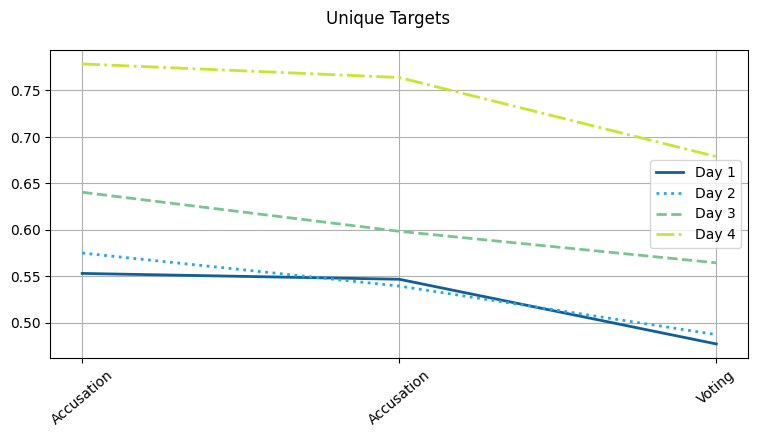

In [15]:
plot_indicator(tpv_stacked[1], indicator_titles[0], 0, day_colors)

When looking at this indicator across games played between the trained agents and other wolf targets, the behavior remains very similar. The biggest difference we can make out here is that because our agents were trained against coordinated wolves, we see the largest drops in unique targets when the werewolves play a coordinated strategy such as CRWolves or CRevWolves.

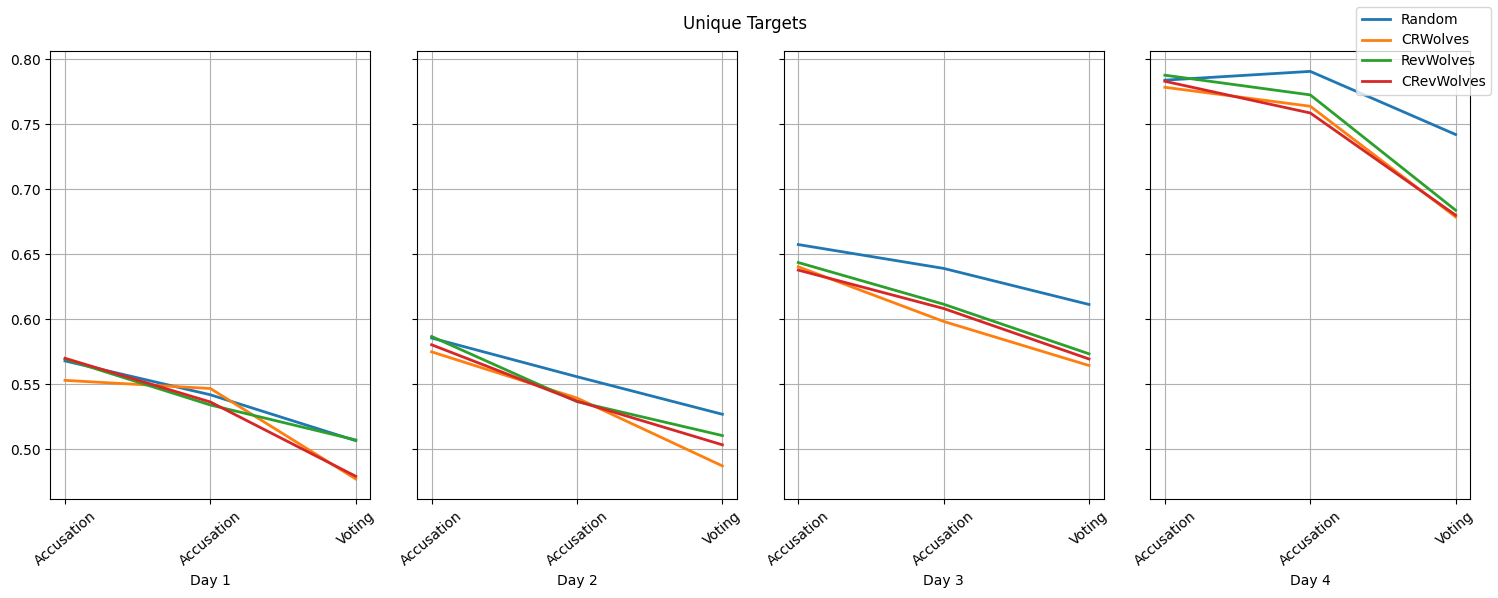

In [16]:
plot_indicator_across_other_wolves(tpv_stacked, indicator_titles[0], 0)

#### Likelihood of self voting

Self-Voting is an indicator that has a negative associated reward. Agents will always be penalized if they target themselves, and given that they can only select a single candidate for executing in plurality voting, a self-vote can be quite disasterous.

We can see that by the very low likelihoods, agents have learned to not do it much, and we can attribute some of this to the soft policy sampling selecting a self target every now and then, and maybe very rarely, agents may do it strategically. Because it tends to trend down throughout the day, trained agents are more comfortable doing it during accusation rounds.

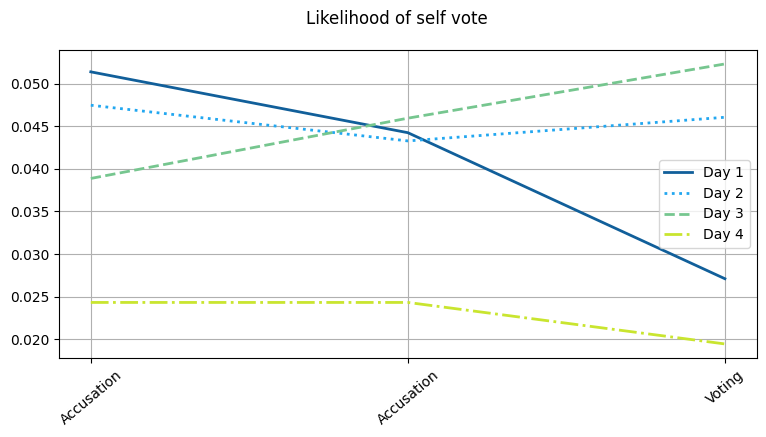

In [9]:
plot_indicator(tpv_stacked[1], indicator_titles[1], 1, day_colors)

Across games versus different policies, we can see similar behaviors, with random wolves causing trained agents to vote for themselves more often.

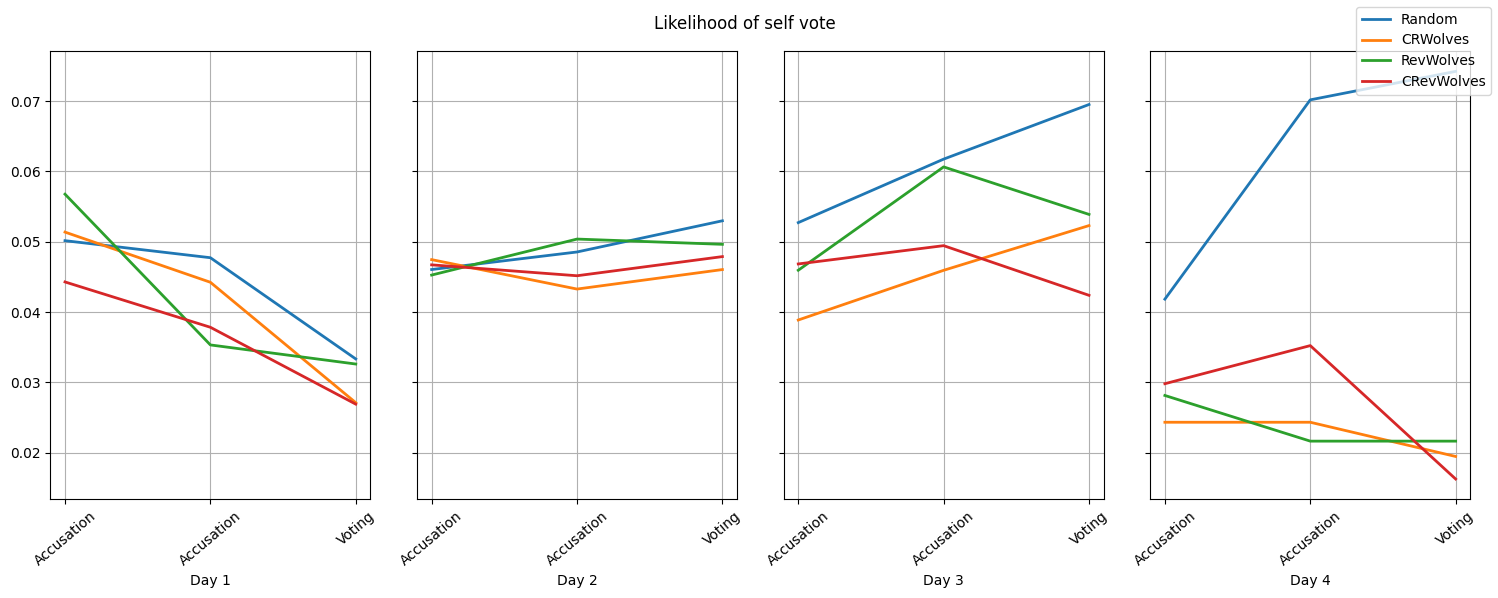

In [10]:
plot_indicator_across_other_wolves(tpv_stacked, indicator_titles[1], 1)

#### Percetange of targets towards wolves

This indicator is straightforward and easy to interpret. The higher the number, the more a wolf is targetted. There are three takeaways here:
1. As agents advance through the phases, votes increasingly target wolves, highlighting some consensus amongst villagers.
2. In the last day, almost every villager targets wolves during voting.
3. When taken in tandem with unique target ratios (our first indicator), we can say that each day, during the first phase, villagers seem to spread out their votes to gather more information, and then sythesize what they see from others and focus their targets on suspected wolves.

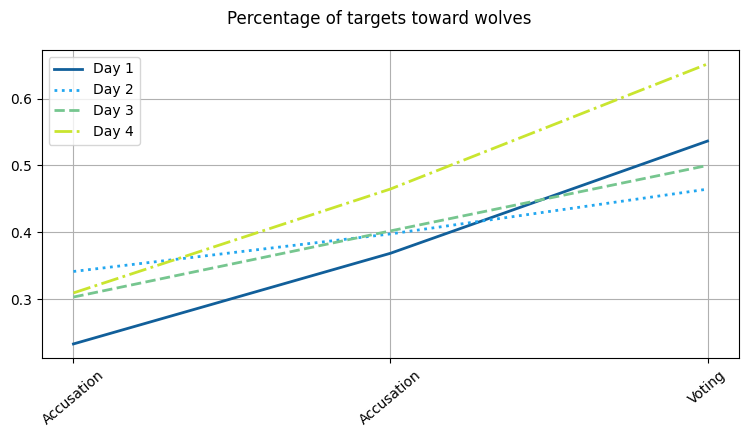

In [11]:
plot_indicator(tpv_stacked[1], indicator_titles[2], 2, day_colors)

We can see similar behavior against other werewolf policies, with the random wolf causing the most trouble. By the last day, when agents have the most information, they are nowhere near as confident against random wolves as opposed to all other policies.

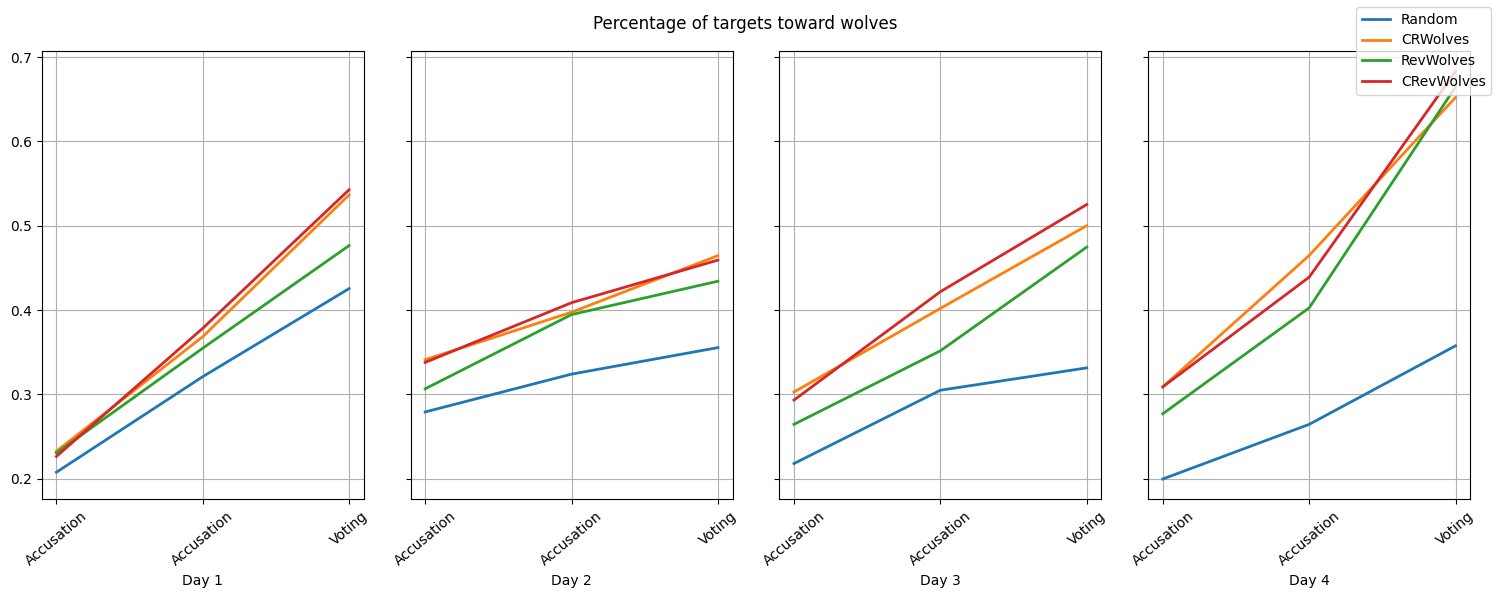

In [12]:
plot_indicator_across_other_wolves(tpv_stacked, indicator_titles[2], 2)

#### Percentage of targets towards dead players

This indicator also has a negative reward associated with it. Every time an agent targets a dead player, they get a negative reward, and their vote is masked by the environment. Given that agents can only select a single candidate in plurality voting, a wasted vote has more of a negative impact towards villagers chances to win.

We can see that throughout the phases in a day, agents target dead players less, with the voting round having the smallest percentage consistently. Voting on accusation days are simply for information, so agents seem to be using these phases to broadcast possible intent, and making sure their target is a viable vote does not seem as important. With $2$ agents dying per day, by the last day, a majority are dead, so it is likely agents have learned to target dead players as a way to signal during accusation rounds.

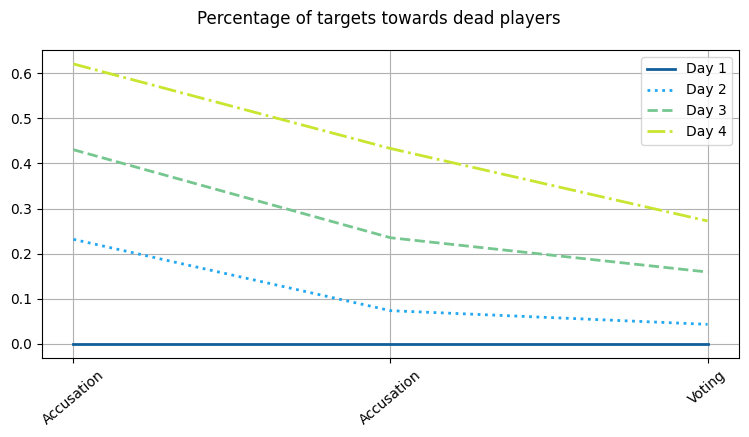

In [13]:
plot_indicator(tpv_stacked[1], indicator_titles[3], 3, day_colors)

Again, we show the indicator between trained agents against different werewolf policies, and the same trend as above is seen in all games. This strengthens our belief that dead players are used as implicit signaling during accusastion phases.

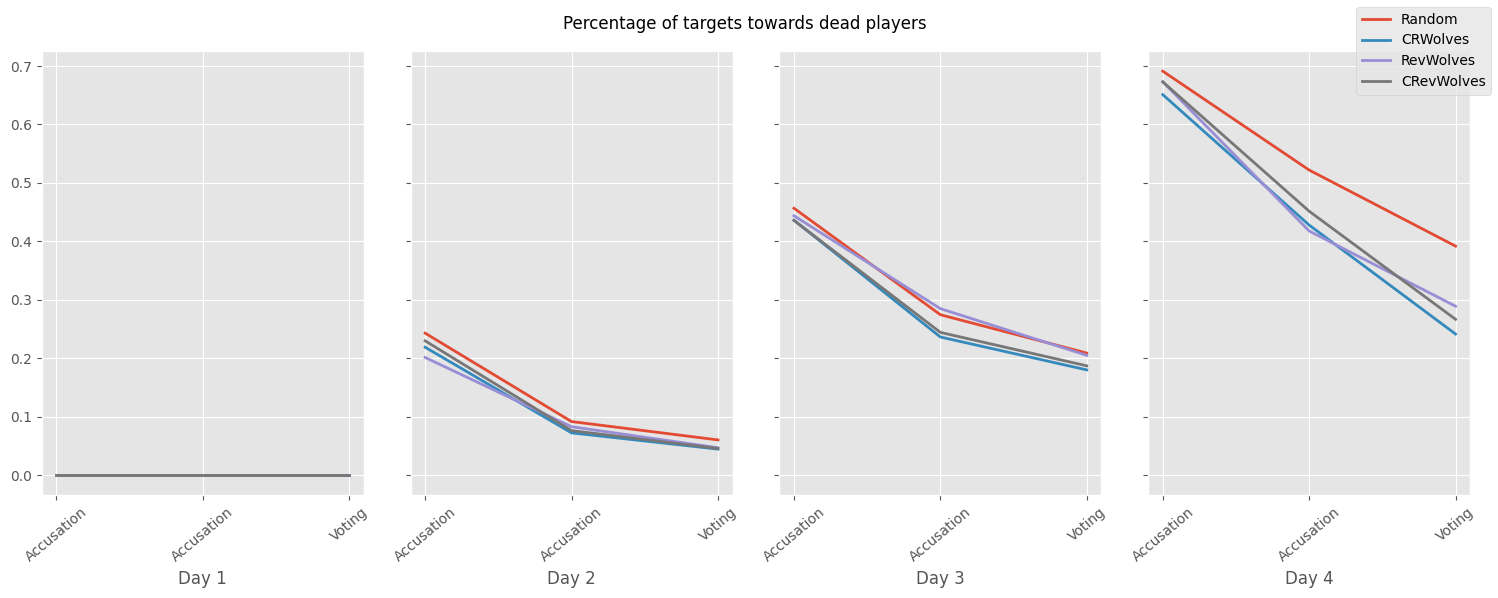

In [167]:
plot_indicator_across_other_wolves(tpv_stacked, indicator_titles[3], 3)

#### Percentage of targets towards dead wolves

WHen taken in consideriation with targets towards dead players, we can see that most of the dead targetting are towards different villagers, not wolves. There may be more complicated indicators that can shed some more light on this connection, but we believe that this further strengthens the idea of implicit communication of roles by targetting dead villagers more than dead wolves.

When taken in conjunction with _percetange of targets towards wolves_, the majority of the targetting is towards suspected wolves that are still alive.

When looking at it upfront, this number is low to begin with, and trends down throughout phases, indicating more signaling, and less desire for trained agents to target dead players in voting rounds, as this will have more disasterous consequences than targetting during accusation phases.

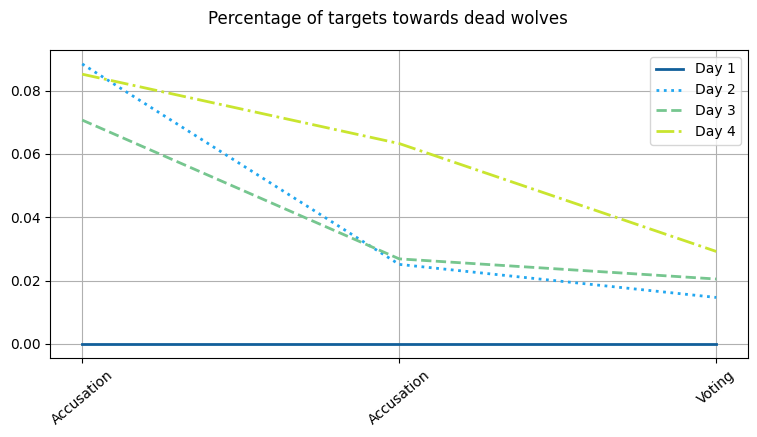

In [14]:
plot_indicator(tpv_stacked[1], indicator_titles[4], 4, day_colors)

These ideas hold throughout games played against different werewolf policies, with no real standouts.

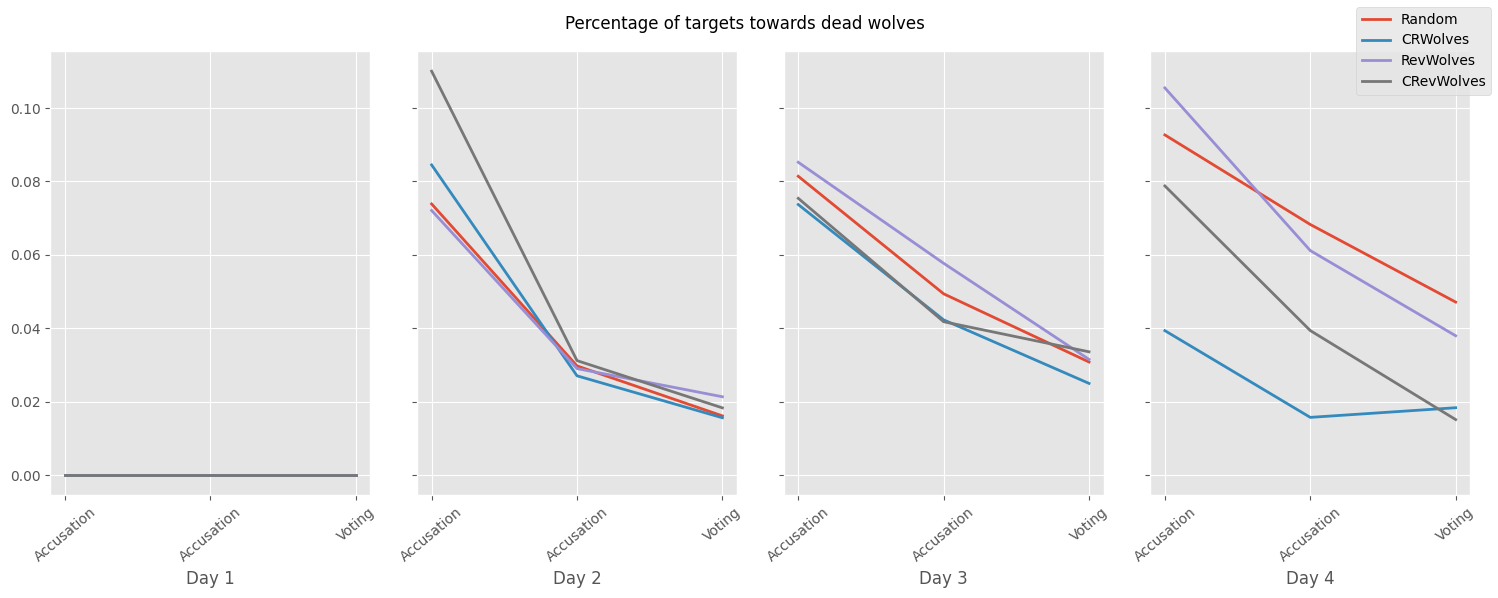

In [168]:
plot_indicator_across_other_wolves(tpv_stacked, indicator_titles[4], 4)